In [1]:
import tensorflow as tf
import logging
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [2]:
# Define dataset paths
TRAIN_DIR = '../data/processed/train/'
TEST_DIR = '../data/processed/test/'
VAL_DIR = '../data/processed/val/'
IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [3]:
# Image preprocessing using image_dataset_from_directory
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 125 files belonging to 2 classes.


In [4]:
class_names = train_data.class_names  # Get class names before transformations
print(class_names)

['no_tumor', 'tumor']


In [5]:
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 27 files belonging to 2 classes.


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 27 files belonging to 2 classes.


In [7]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# VGG16 Model with transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

In [9]:
# Custom classifier
top_model = models.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [10]:
# Combine VGG16 and classifier
model = models.Sequential([base_model, top_model])

In [11]:
top_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 1)                 6423041   
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Compile the model with F1 score included
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [14]:
def save_model_architecture(model, filepath="model_vgg_cnn.png"):
    tf.keras.utils.plot_model(model, to_file=filepath, show_shapes=True)
    print(f"Model architecture saved to {filepath}")
save_model_architecture(model)

Model architecture saved to model_vgg_cnn.png


In [15]:
# Train the model
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20


2025-04-13 15:33:42.555524: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 15s 4s/step - loss: 8.1010 - accuracy: 0.5520 - precision: 0.5385 - recall: 0.5738 - val_loss: 4.4488 - val_accuracy: 0.5185 - val_precision: 0.5000 - val_recall: 0.4615
Epoch 2/20
4/4 [==============================] - 14s 4s/step - loss: 6.2045 - accuracy: 0.6480 - precision: 0.6441 - recall: 0.6230 - val_loss: 3.9086 - val_accuracy: 0.5926 - val_precision: 0.5833 - val_recall: 0.5385
Epoch 3/20
4/4 [==============================] - 14s 4s/step - loss: 5.3180 - accuracy: 0.6400 - precision: 0.6333 - recall: 0.6230 - val_loss: 3.5475 - val_accuracy: 0.6296 - val_precision: 0.6154 - val_recall: 0.6154
Epoch 4/20
4/4 [==============================] - 14s 4s/step - loss: 3.9841 - accuracy: 0.7040 - precision: 0.6818 - recall: 0.7377 - val_loss: 3.2912 - val_accuracy: 0.7037 - val_precision: 0.6923 - val_recall: 0.6923
Epoch 5/20
4/4 [==============================] - 14s 4s/step - loss: 2.1894 - accuracy: 0.7680 - precision: 0.7857 - recall: 0.721

In [16]:
# Evaluate the model on test data
evaluation_results = model.evaluate(test_data)

test_loss = evaluation_results[0]  # Loss
test_acc = evaluation_results[1]   # Accuracy
test_precision = evaluation_results[2]  # Precision
test_recall = evaluation_results[3]     # Recall

print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

1/1 [==============================] - 2s 2s/step - loss: 3.2185 - accuracy: 0.7407 - precision: 0.7500 - recall: 0.6923
Test Loss: 3.22
Test Accuracy: 74.07%
Test Precision: 0.75
Test Recall: 0.69


In [17]:
# Generate predictions and confusion matrix
y_pred = []
y_true = []
for images, labels in test_data:
    predictions = model.predict(images)
    pred_classes = (predictions > 0.5).astype(int).flatten()  # Convert to binary class (0 or 1)
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

1/1 [==============================] - 2s 2s/step


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [19]:
def plot_keras_val_accuracy_and_loss(history):
    """
    Plots validation accuracy and validation loss from a Keras History object using dual Y-axes.
    
    Parameters:
        history: Keras History object returned by model.fit()
    """
    val_accuracy = history.history.get('val_accuracy')
    val_loss = history.history.get('val_loss')

    if val_accuracy is None or val_loss is None:
        print("Make sure your model was compiled with 'accuracy' as a metric and validated with validation data.")
        return

    fig, ax1 = plt.subplots()

    color = 'blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Accuracy', color=color)
    ax1.plot(val_accuracy, color=color, label='Val Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'red'
    ax2.set_ylabel('Validation Loss', color=color)
    ax2.plot(val_loss, color=color, label='Val Loss')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Validation Accuracy and Loss')
    plt.show()

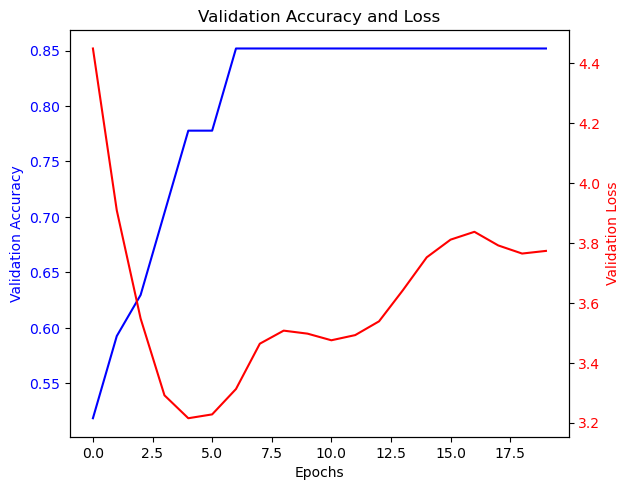

In [20]:
plot_keras_val_accuracy_and_loss(history)

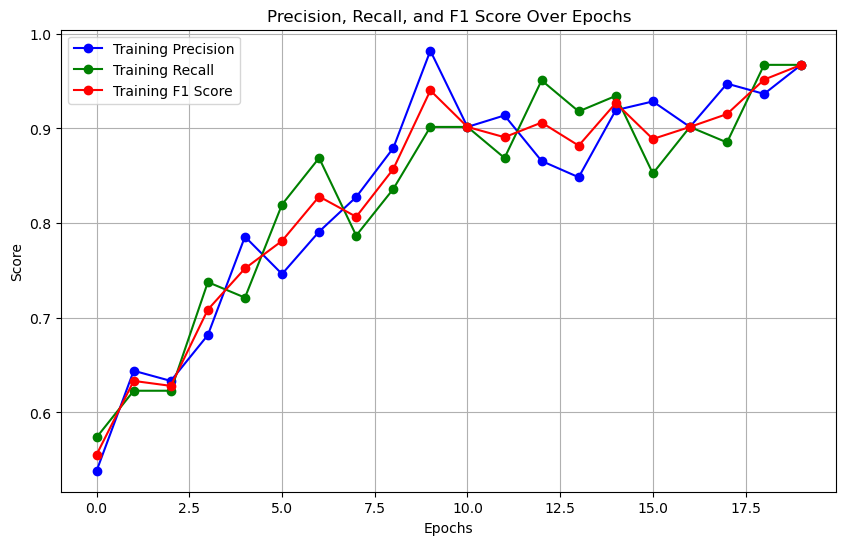

In [21]:
# Extract precision and recall from the history object
eval_precision = history.history.get('precision', [])
eval_recall = history.history.get('recall', [])

# Calculate F1 score from precision and recall
eval_f1 = [2 * (p * r) / (p + r) if p + r > 0 else 0 for p, r in zip(eval_precision, eval_recall)]

# Ensure all metrics have the same length
if len(eval_precision) == len(eval_recall) == len(eval_f1):
    # Plotting precision, recall, and F1 score
    plt.figure(figsize=(10, 6))
    plt.plot(eval_precision, label='Training Precision', marker='o', color='blue')
    plt.plot(eval_recall, label='Training Recall', marker='o', color='green')
    plt.plot(eval_f1, label='Training F1 Score', marker='o', color='red')

    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Mismatch in the number of epochs for precision, recall, and F1 score. Please check the history object.")

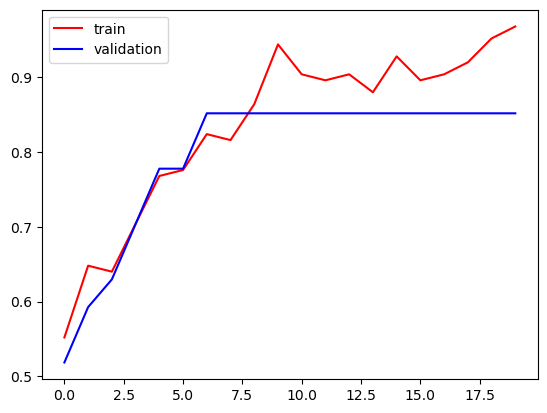

In [22]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

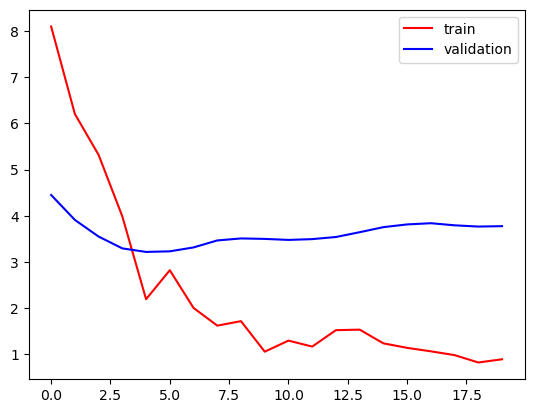

In [23]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [24]:
import json

def save_keras_history_as_json(history, filename="keras_log_history.json"):
    """
    Save Keras training history as a list of dicts (one per epoch) into a JSON file.
    
    Parameters:
        history: Keras History object returned by model.fit()
        filename: Output filename for the JSON log
    """
    log_history = []
    metrics = history.history.keys()
    num_epochs = len(history.history['loss'])

    for epoch in range(num_epochs):
        epoch_log = {'epoch': epoch + 1}
        for metric in metrics:
            epoch_log[metric] = history.history[metric][epoch]
        log_history.append(epoch_log)

    with open(filename, "w") as f:
        json.dump(log_history, f, indent=4)

    print(f"Saved training log to: {filename}")


In [25]:
save_keras_history_as_json(history)

Saved training log to: keras_log_history.json


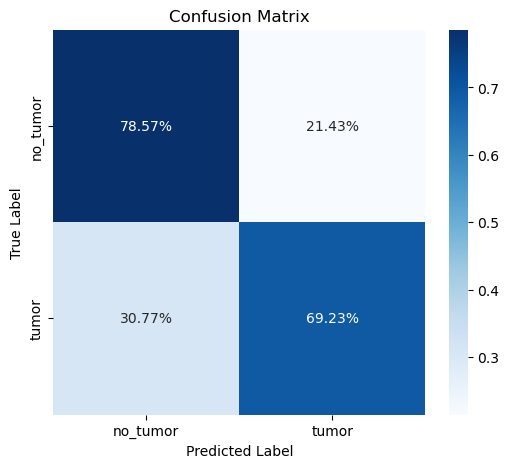

In [26]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Save the model
model.save("VGG_CNN_model.h5")

1/1 [==============================] - 3s 3s/step


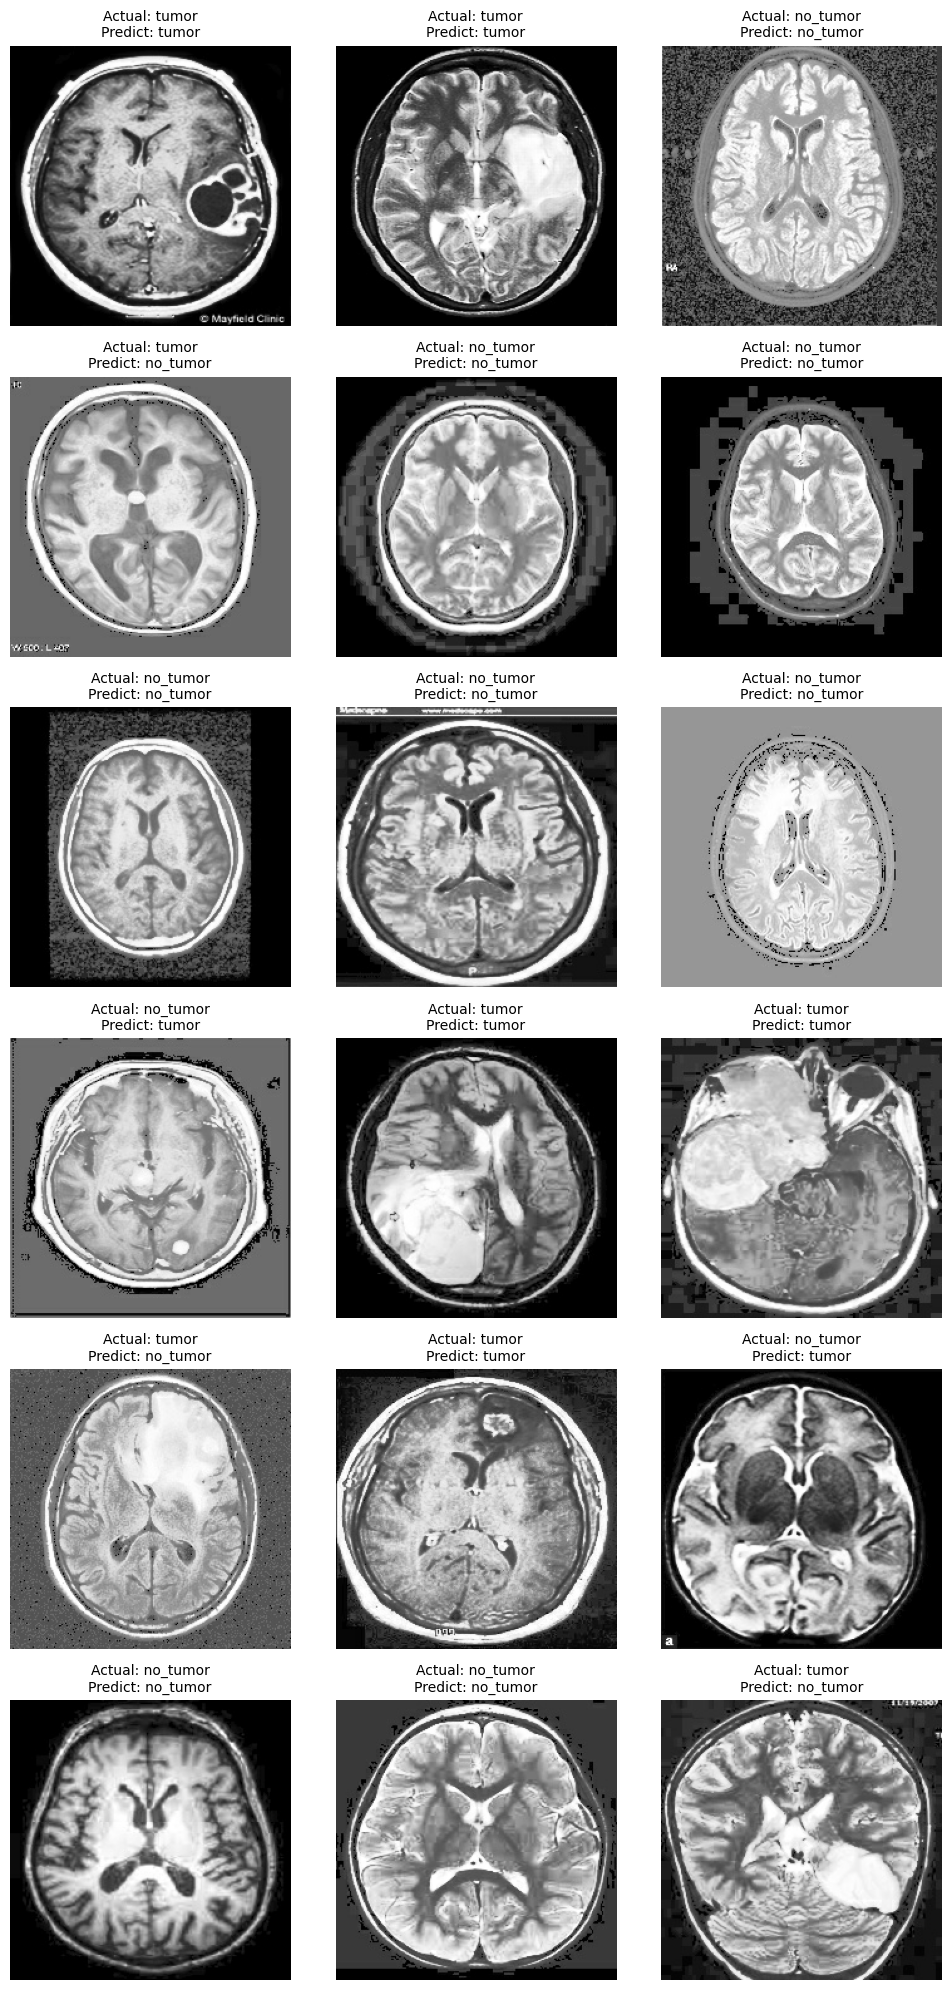

In [28]:
# Generate predictions
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert to binary class (0 or 1)

# Plot images with actual and predicted labels
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 20))
index = 0

for image, label in test_data.unbatch():
    if index >= 18:  # Stop after displaying 18 images
        break

    # Convert image tensor to numpy array
    image = image.numpy().squeeze()  # Remove extra dimensions if grayscale
    label = int(label.numpy().item())  # Extract scalar value properly

    # Access the current subplot
    ax = axes.flat[index]

    # Display the image
    if image.ndim == 2:  # If grayscale
        ax.imshow(image, cmap='gray')
    else:  # If RGB
        ax.imshow(image.astype("uint8"))

    # Get actual and predicted class names
    actual_class = class_names[label]
    predicted_class = class_names[y_pred_classes[index]]

    # Set title and remove axis
    ax.set_title(f'Actual: {actual_class}\nPredict: {predicted_class}', fontsize=10)
    ax.axis('off')

    index += 1  # Move to the next subplot

plt.tight_layout()
plt.show()

In [29]:
from tensorflow.keras.models import load_model

model = load_model("VGG_CNN_model.h5")

1/1 [==============================] - 0s 156ms/step
Predicted Probability: 0.2779
Predicted: no_tumor


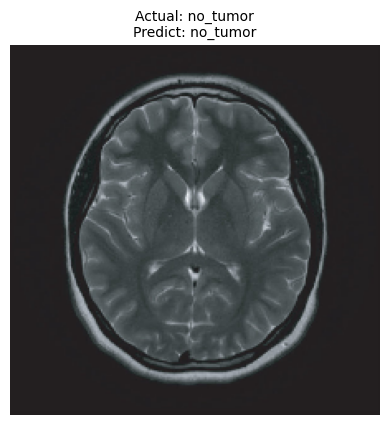

In [37]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
# Set image path (your new image)
img_path1 = "../data/tumor_internet/Brain-tumor-dataset-a-no-tumor-and-b-brain-tumor.png"
# Set same size as training images
IMG_SIZE = (224, 224)

# Load and preprocess the image
img = image.load_img(img_path1, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (if model trained with normalization)

# Predict
prediction = model.predict(img_array)

# If sigmoid is used for binary classification:
probability = prediction[0][0]
print(f"Predicted Probability: {probability:.4f}")

if probability > 0.5:
    print("Predicted: tumor")
else:
    print("Predicted: no_tumor")

plt.imshow(img)
plt.title(f"Actual: no_tumor\nPredict: {'tumor' if probability > 0.5 else 'no_tumor'}", fontsize=10)
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 167ms/step
Predicted Probability: 0.3262
Predicted class: Class 0


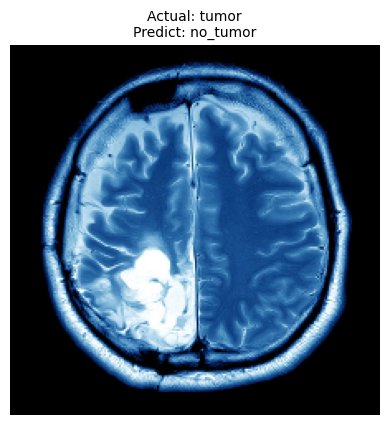

In [36]:
# Set image path (your new image)
img_path2 = "../data/tumor_internet/Brain-MRI-Scan-Results.png"
# Set same size as training images
IMG_SIZE = (224, 224)

# Load and preprocess the image
img = image.load_img(img_path2, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (if model trained with normalization)

# Predict
prediction = model.predict(img_array)

# If sigmoid is used for binary classification:
probability = prediction[0][0]
print(f"Predicted Probability: {probability:.4f}")

if probability > 0.5:
    print("Predicted class: Class 1")
else:
    print("Predicted class: Class 0")

plt.imshow(img)
plt.title(f"Actual: tumor\nPredict: {'tumor' if probability > 0.5 else 'no_tumor'}", fontsize=10)
plt.axis('off')
plt.show()